In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import glob

from tqdm import tqdm

import itertools
import numpy as np

import matplotlib.pyplot as plt
import joblib
from xgboost import XGBClassifier

from scipy.ndimage import label

import os
from matplotlib import gridspec

In [ ]:
x_columns = ['land_cover',
       'dem', 't2m', 'd2m', 'u10',
       'v10', 'tp','swvl1', 'sp']
x_columns_with_location = ['land_cover',
       'dem', 't2m', 'd2m', 'u10',
       'v10', 'tp','swvl1', 'sp', 'lon', 'lat']
y_column = 'burn'

In [ ]:
if os.path.exists('Training_data/baseline_df.csv'):
    final_df = pd.read_csv('Training_data/baseline_df.csv')

else:
    # original data by request
    csv_files = sorted(glob.glob("I-GUIDE summer school/data/daily_csv/2024-*.csv"))

    burn_samples = []
    nonburn_samples = []

    max_burn_per_day = 5000
    nonburn_ratio = 1

    for f in tqdm(csv_files, desc="stratified sampling"):
        df = pd.read_csv(f, usecols=x_columns_with_location + [y_column])
        df.dropna(subset=x_columns_with_location + [y_column], inplace=True)

        burn_subset = df[df[y_column] == 1]
        nonburn_subset = df[df[y_column] == 0]

        if len(burn_subset) == 0 or len(nonburn_subset) == 0:
            continue  # skip days without burns or non-burns

        # burns
        n_burn = min(len(burn_subset), max_burn_per_day)
        sampled_burns = burn_subset.sample(n=n_burn, random_state=42)

        # non-burns
        n_nonburn = min(len(nonburn_subset), nonburn_ratio * n_burn)
        sampled_nonburns = nonburn_subset.sample(n=n_nonburn, random_state=42)

        burn_samples.append(sampled_burns)
        nonburn_samples.append(sampled_nonburns)

    burn_df = pd.concat(burn_samples, ignore_index=True)
    nonburn_df = pd.concat(nonburn_samples, ignore_index=True)
    final_df = pd.concat([burn_df, nonburn_df]).sample(frac=1, random_state=42).reset_index(drop=True)

    true_ratio = final_df[y_column].mean()
    print(f"Final dataset size: {len(final_df)}")
    print(f"Burn ratio: {true_ratio:.8f} ({true_ratio * 100:.6f}%)")

In [ ]:
X = final_df[x_columns]
y = final_df[y_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42, stratify=y)

# Classification - Random Forest

In [ ]:
model_fname = "models/random_forest_model_ratio_1.pkl"

if os.path.exists(model_fname):
    model = joblib.load(model_fname)
else:
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=20,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )

    model.fit(X_train, y_train)

    joblib.dump(model, model_fname)

In [ ]:
dates = [file_name.split('.')[0] for file_name in os.listdir("Testing_data")]
dates.sort()

2024-06-14 3941
Accuracy: 0.9986398198486804
Precision: 0.09566099974625729
Recall: 0.09352517985611511
F1 Score: 0.09458103361766182


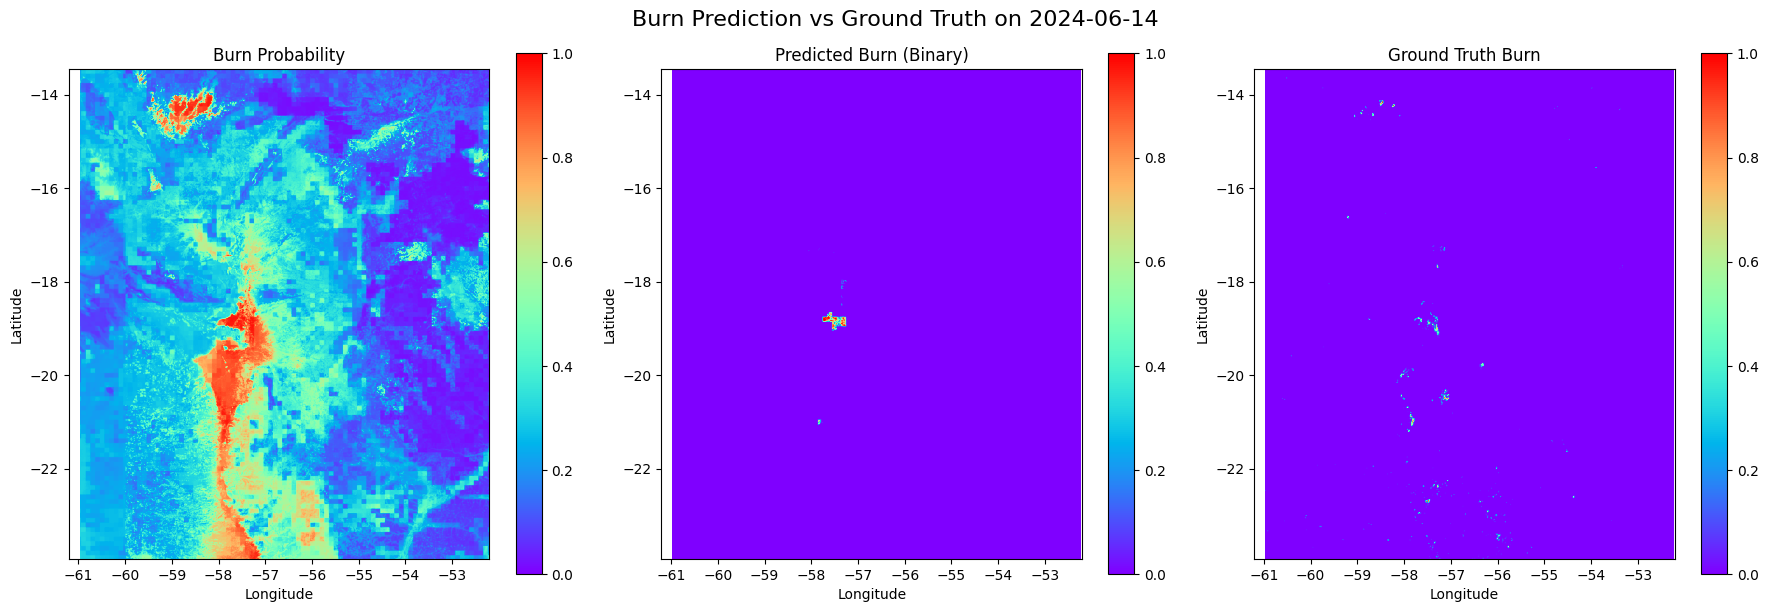

2024-06-15 5149
Accuracy: 0.9987694684970744
Precision: 0.09030879782482035
Recall: 0.20121159671138036
F1 Score: 0.12466487935656836


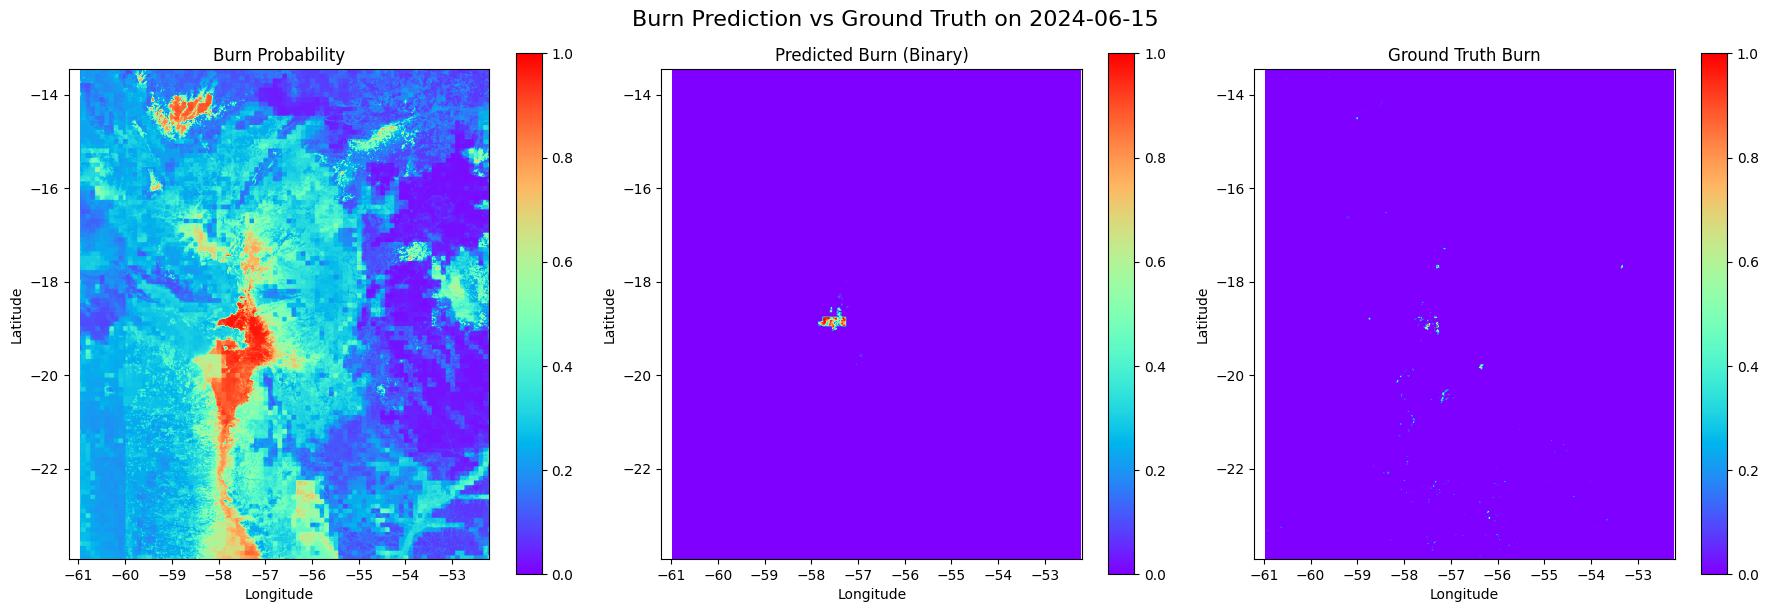

2024-06-16 1174
Accuracy: 0.9995055260851949
Precision: 0.051959114139693355
Recall: 0.03880407124681934
F1 Score: 0.04442825928623452


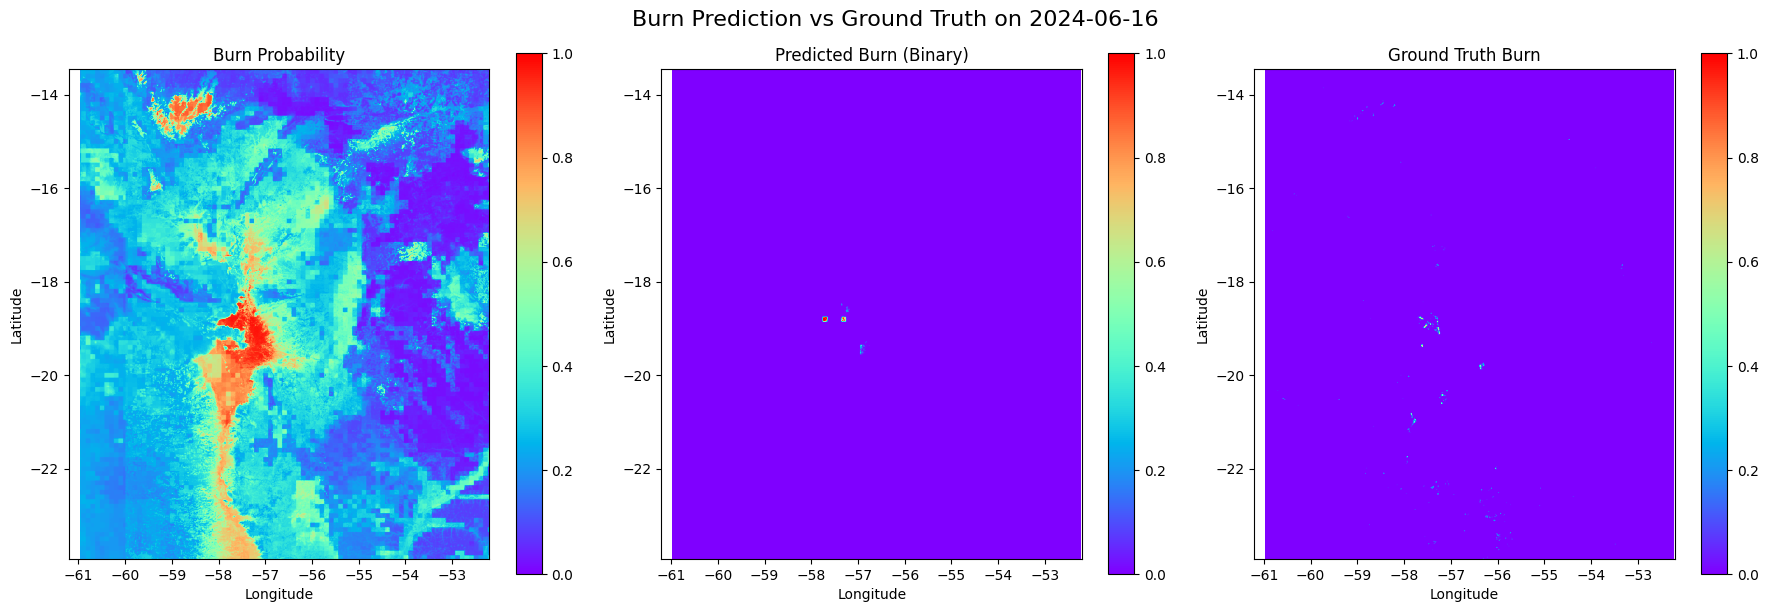

2024-06-17 8639
Accuracy: 0.9981952832766434
Precision: 0.01817339969903924
Recall: 0.1253993610223642
F1 Score: 0.031746031746031744


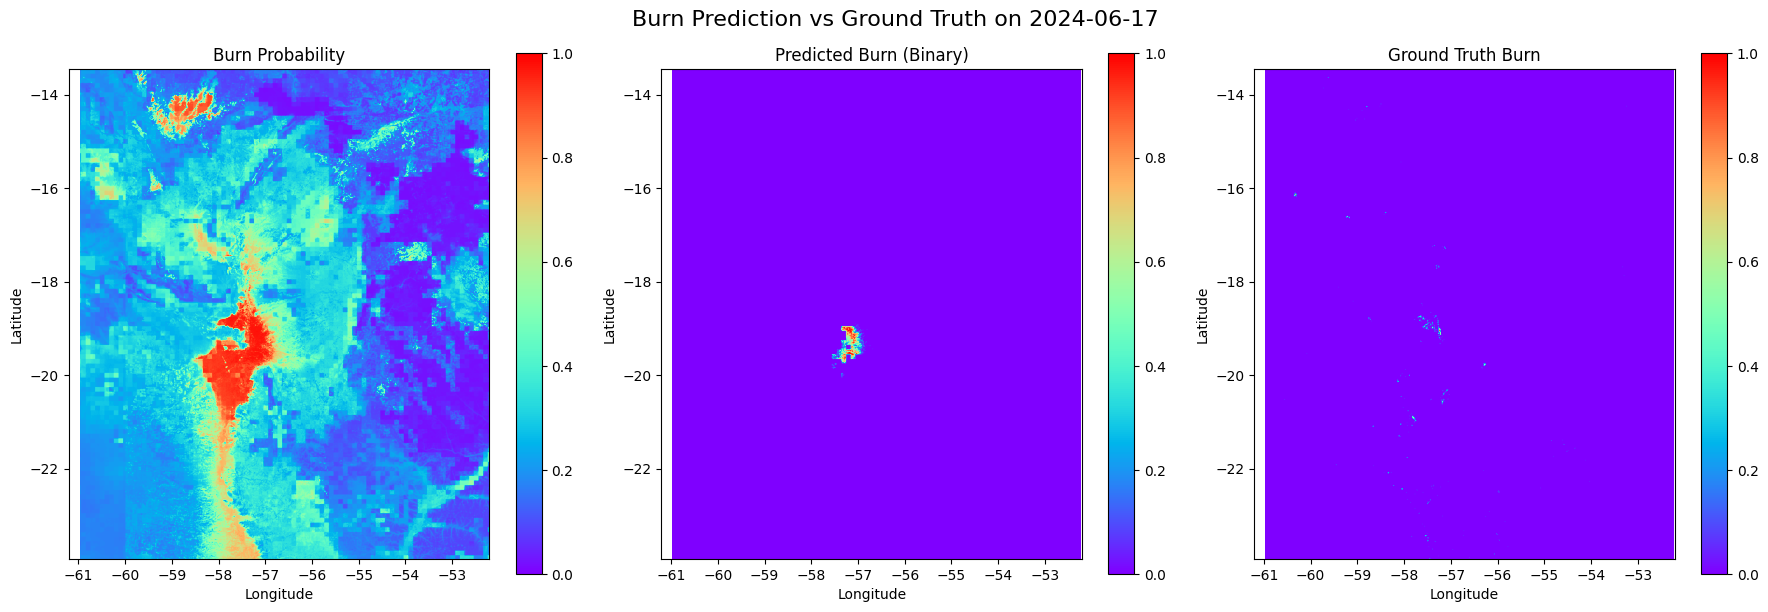

2024-06-18 9832
Accuracy: 0.9981455343766783
Precision: 0.06997558991049634
Recall: 0.4967509025270758
F1 Score: 0.12267094588570919


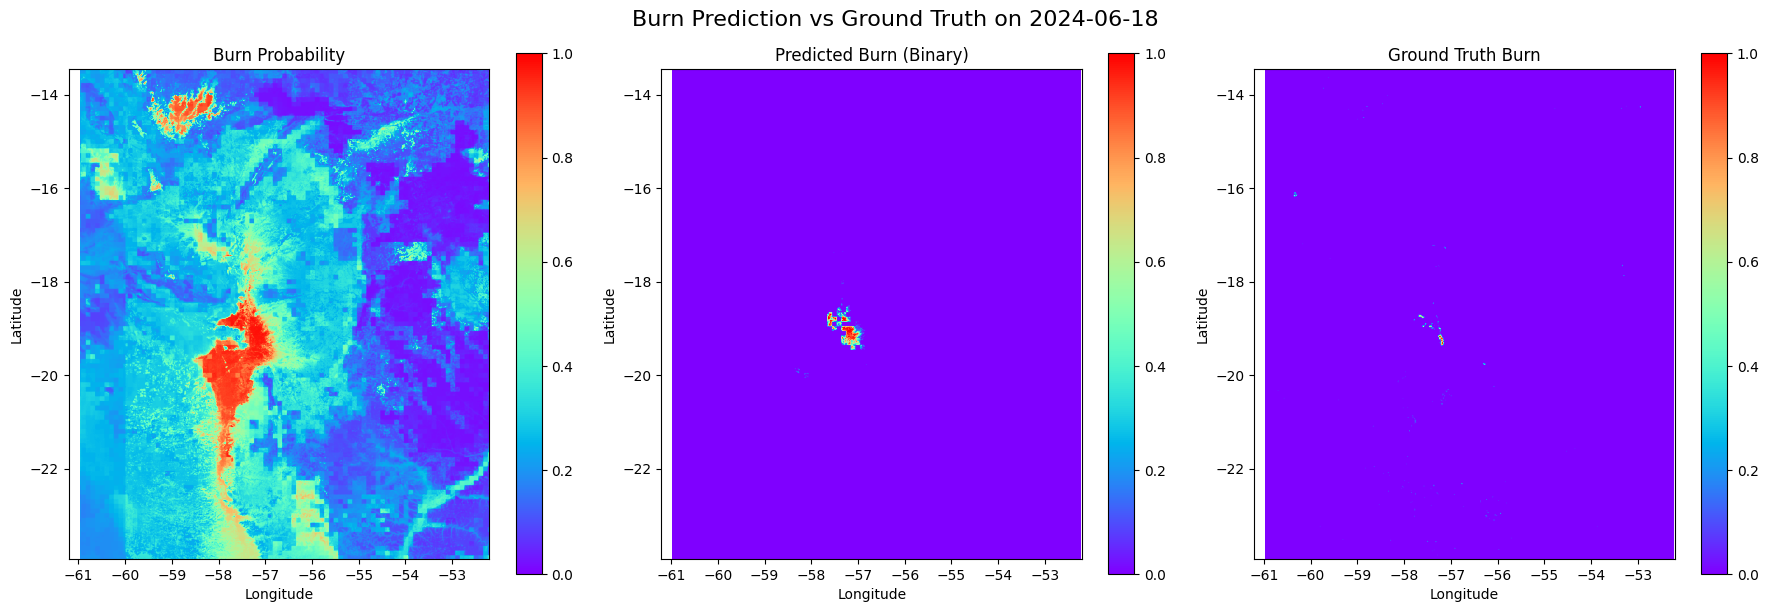

2024-06-19 4966
Accuracy: 0.9987977349175091
Precision: 0.018123238018525976
Recall: 0.056461731493099125
F1 Score: 0.027439024390243903


In [ ]:
for target_date in dates:
    target_file = f"Testing_data/{target_date}.csv"

    # Read one day's data
    df_full  = pd.read_csv(target_file, usecols=x_columns_with_location + [y_column])
    df_pred = df_full.dropna(subset=x_columns_with_location + [y_column])

    X_pred = df_pred[x_columns]
    y_true = df_pred[y_column].values

    # pred
    y_prob = model.predict_proba(X_pred)[:, 1]
    y_pred = (y_prob > 0.975).astype(int)

    print(target_date, np.sum(y_pred))

    if np.sum(y_pred) > 5:

        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Precision:", precision_score(y_true, y_pred))
        print("Recall:", recall_score(y_true, y_pred))
        print("F1 Score:", f1_score(y_true, y_pred))

        # df to grid
        lats = np.sort(df_full['lat'].unique())
        lons = np.sort(df_full['lon'].unique())
        H, W = len(lats), len(lons)

        lat_to_idx = {lat: i for i, lat in enumerate(lats)}
        lon_to_idx = {lon: i for i, lon in enumerate(lons)}

        burn_prob_image = np.full((H, W), np.nan)
        burn_pred_image = np.full((H, W), np.nan)
        burn_true_image = np.full((H, W), np.nan)

        for k, row in enumerate(df_pred.itertuples()):
            i = lat_to_idx[row.lat]
            j = lon_to_idx[row.lon]
            burn_prob_image[i, j] = y_prob[k]
            burn_pred_image[i, j] = y_pred[k]
            burn_true_image[i, j] = y_true[k]

        extent = [lons.min(), lons.max(), lats.min(), lats.max()]

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        im0 = axes[0].imshow(burn_prob_image, origin='lower', cmap='rainbow', vmin=0, vmax=1, extent=extent)
        axes[0].set_title("Burn Probability")
        axes[0].set_xlabel("Longitude")
        axes[0].set_ylabel("Latitude")
        plt.colorbar(im0, ax=axes[0])

        im1 = axes[1].imshow(burn_pred_image, origin='lower', cmap='rainbow', vmin=0, vmax=1, extent=extent)
        axes[1].set_title("Predicted Burn (Binary)")
        axes[1].set_xlabel("Longitude")
        axes[1].set_ylabel("Latitude")
        plt.colorbar(im1, ax=axes[1])

        im2 = axes[2].imshow(burn_true_image, origin='lower', cmap='rainbow', vmin=0, vmax=1, extent=extent)
        axes[2].set_title("Ground Truth Burn")
        axes[2].set_xlabel("Longitude")
        axes[2].set_ylabel("Latitude")
        plt.colorbar(im2, ax=axes[2])

        plt.suptitle(f"Burn Prediction vs Ground Truth on {target_date}", fontsize=16)
        plt.tight_layout()
        plt.show()

Accuracy: 0.9987694684970744
Precision: 0.09030879782482035
Recall: 0.20121159671138036
F1 Score: 0.12466487935656836


Accuracy: 0.9995055260851949
Precision: 0.051959114139693355
Recall: 0.03880407124681934
F1 Score: 0.04442825928623452


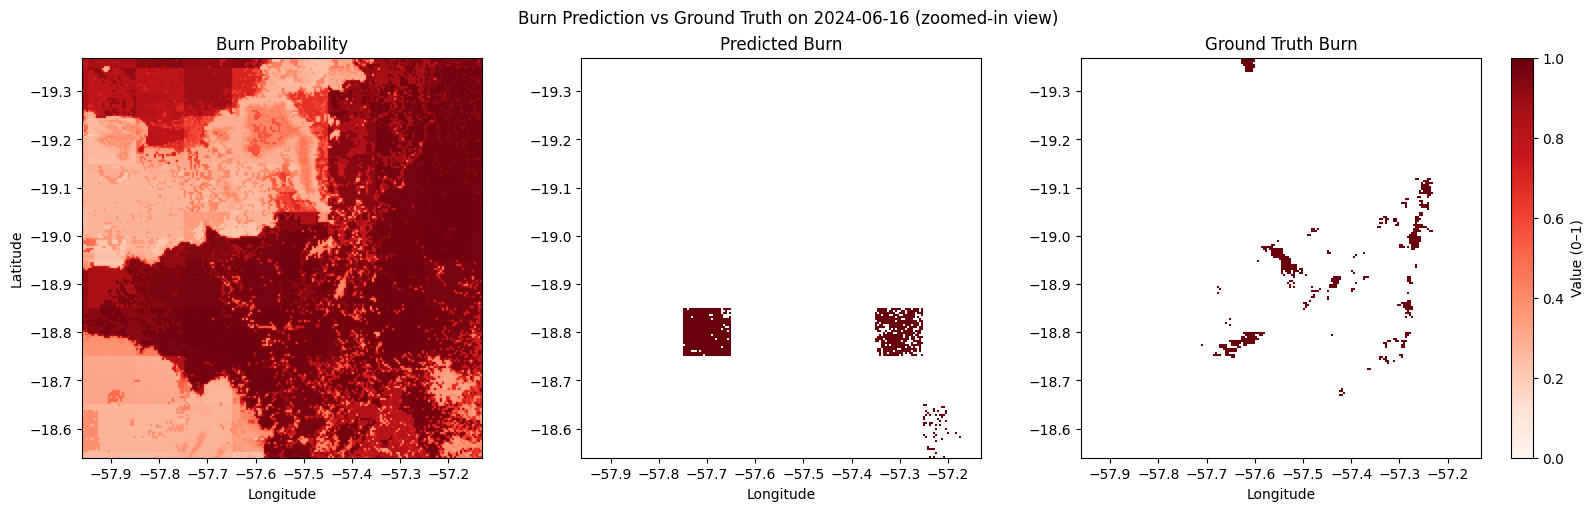

Accuracy: 0.9981952832766434
Precision: 0.01817339969903924
Recall: 0.1253993610223642
F1 Score: 0.031746031746031744


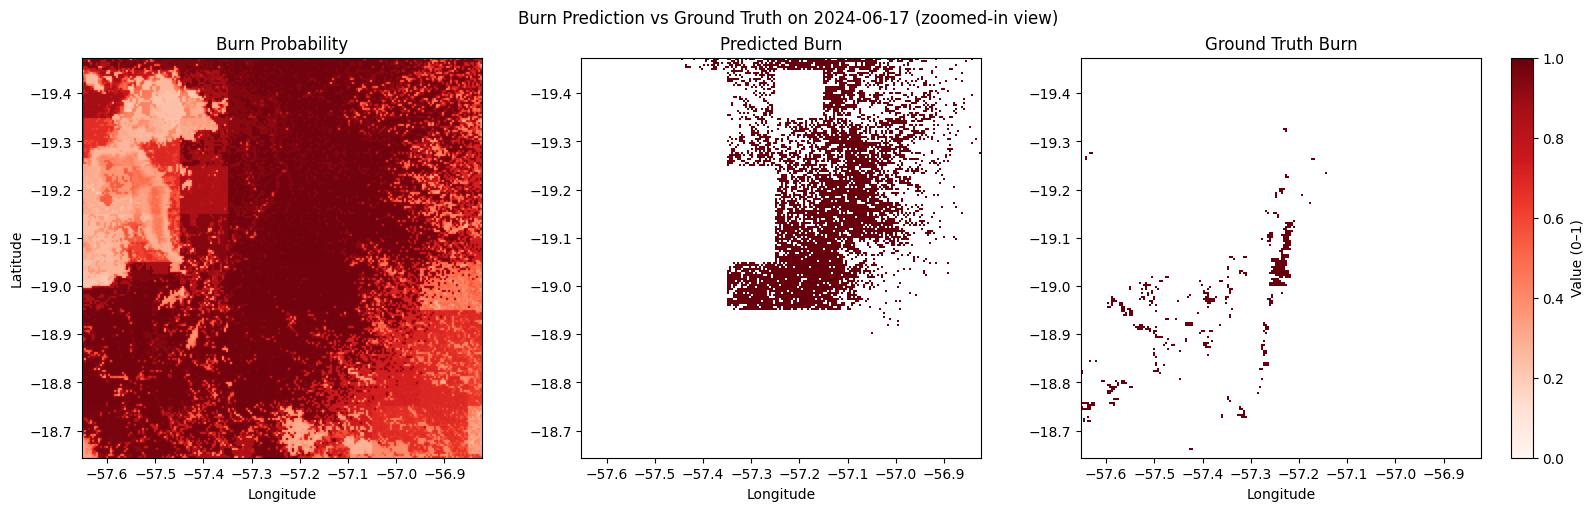

Accuracy: 0.9981455343766783
Precision: 0.06997558991049634
Recall: 0.4967509025270758
F1 Score: 0.12267094588570919


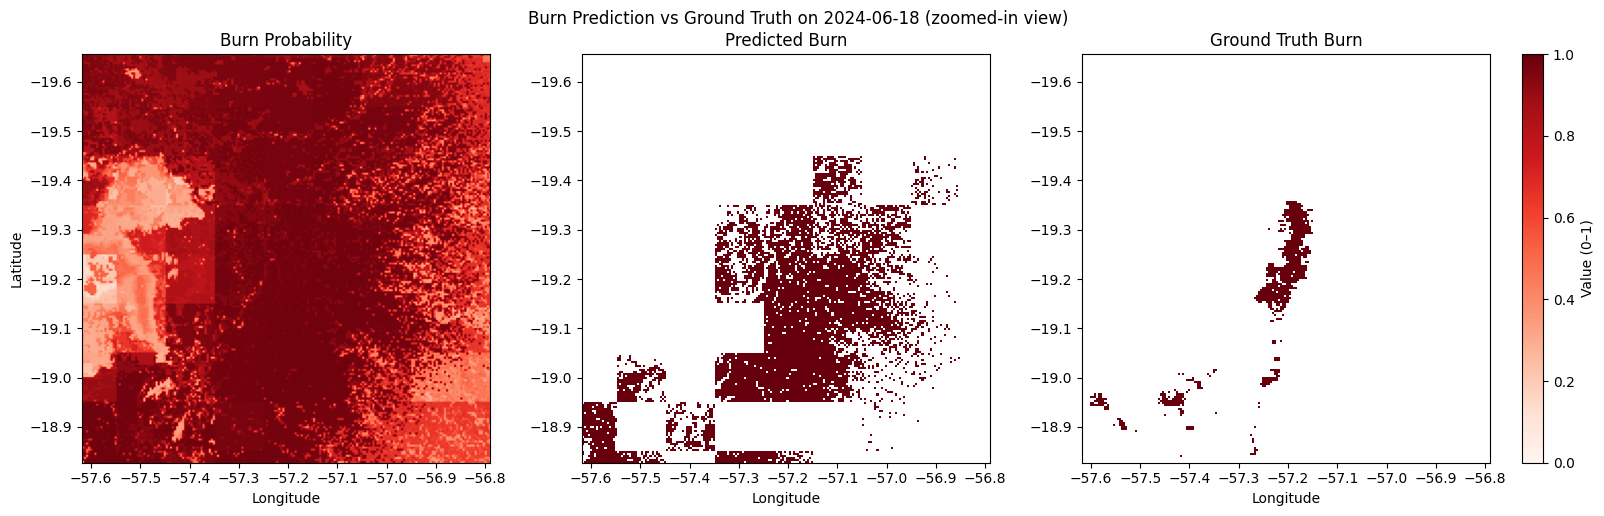

Accuracy: 0.9987977349175091
Precision: 0.018123238018525976
Recall: 0.056461731493099125
F1 Score: 0.027439024390243903


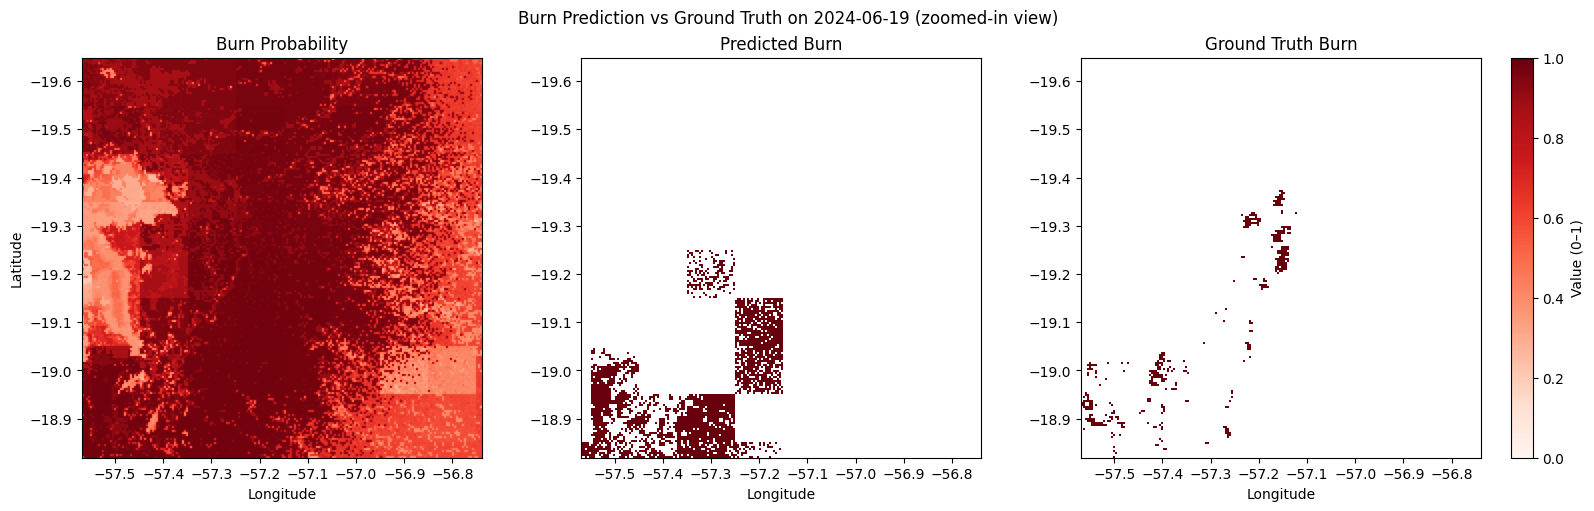

In [ ]:
prob_threshold = 0.975

for target_date in dates[45:50]:
    target_file = f"/yu/s1/I-GUIDE summer school/data/daily_csv/{target_date}.csv"

    # Read one day's data
    df_full  = pd.read_csv(target_file, usecols=x_columns_with_location + [y_column])
    df_pred = df_full.dropna(subset=x_columns_with_location + [y_column])

    X_pred = df_pred[x_columns]
    y_true = df_pred[y_column].values

    # pred
    y_prob = model.predict_proba(X_pred)[:, 1]
    y_pred = (y_prob > prob_threshold).astype(int)


    if np.sum(y_pred) > 5:

        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Precision:", precision_score(y_true, y_pred))
        print("Recall:", recall_score(y_true, y_pred))
        print("F1 Score:", f1_score(y_true, y_pred))

        # df to grid
        lats = np.sort(df_full['lat'].unique())
        lons = np.sort(df_full['lon'].unique())
        H, W = len(lats), len(lons)

        lat_to_idx = {lat: i for i, lat in enumerate(lats)}
        lon_to_idx = {lon: i for i, lon in enumerate(lons)}

        burn_prob_image = np.full((H, W), np.nan)
        burn_pred_image = np.full((H, W), np.nan)
        burn_true_image = np.full((H, W), np.nan)

        for k, row in enumerate(df_pred.itertuples()):
            i = lat_to_idx[row.lat]
            j = lon_to_idx[row.lon]
            burn_prob_image[i, j] = y_prob[k]
            burn_pred_image[i, j] = y_pred[k]
            burn_true_image[i, j] = y_true[k]

        mask = burn_true_image > prob_threshold

        # Find connected components
        structure = np.ones((3, 3))  # 8-connectivity
        labeled_array, num_features = label(mask, structure=structure)

        # Count pixels in each component
        sizes = np.bincount(labeled_array.ravel())
        sizes[0] = 0  # background = 0

        # Find the label of the largest component
        largest_label = sizes.argmax()

        # Mask to keep only the largest cluster
        largest_cluster_mask = labeled_array == largest_label

        # Get bounding box of this cluster
        rows, cols = np.where(largest_cluster_mask)

        center_row = int(np.mean(rows))
        center_col = int(np.mean(cols))

        crop_size = 200
        half_crop = crop_size // 2

        # Ensure the window stays within bounds
        row_min = max(center_row - half_crop, 0)
        row_max = min(center_row + half_crop, burn_prob_image.shape[0])
        col_min = max(center_col - half_crop, 0)
        col_max = min(center_col + half_crop, burn_prob_image.shape[1])

        burn_prob_crop = burn_prob_image[row_min:row_max, col_min:col_max]
        burn_pred_crop = burn_pred_image[row_min:row_max, col_min:col_max]
        burn_true_crop = burn_true_image[row_min:row_max, col_min:col_max]

        lat_crop = lats[row_min:row_max]
        lon_crop = lons[col_min:col_max]

        fig = plt.figure(figsize=(16, 5), constrained_layout=True)
        gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], figure=fig)

        # Create first axis normally
        axs0 = fig.add_subplot(gs[0])
        # Share y with axs0
        axs1 = fig.add_subplot(gs[1], sharey=axs0)
        axs2 = fig.add_subplot(gs[2], sharey=axs0)
        axs = [axs0, axs1, axs2]

        # Colorbar axis
        cax = fig.add_subplot(gs[3])

        vmin, vmax = 0.0, 1.0

        # Burn probability
        im0 = axs[0].imshow(burn_prob_crop, cmap='Reds', vmin=vmin, vmax=vmax,
                            extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]])
        axs[0].set_title("Burn Probability")
        axs[0].set_xlabel("Longitude")
        axs[0].set_ylabel("Latitude")

        reds = plt.colormaps['Reds'].copy()
        reds.set_bad(color='white')

        # Predicted burn
        burn_pred_crop[burn_pred_crop == 0] = np.nan
        im1 = axs[1].imshow(burn_pred_crop, cmap=reds, vmin=vmin, vmax=vmax,
                            extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]],interpolation='nearest')
        axs[1].set_title("Predicted Burn")
        axs[1].set_xlabel("Longitude")

        # Ground truth
        burn_true_crop[burn_true_crop == 0] = np.nan
        im2 = axs[2].imshow(burn_true_crop, cmap=reds, vmin=vmin, vmax=vmax,
                            extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]],interpolation='nearest')
        axs[2].set_title("Ground Truth Burn")
        axs[2].set_xlabel("Longitude")

        # Shared colorbar
        cbar = fig.colorbar(im2, cax=cax)
        cbar.set_label("Value (0–1)")

        fig.suptitle(f"Burn Prediction vs Ground Truth on {target_date} (zoomed-in view)")
        plt.show()

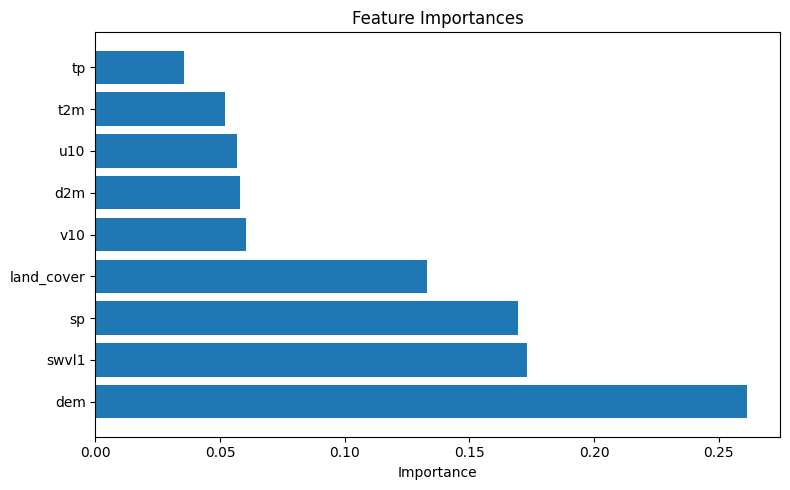

In [ ]:
# Compute feature importances
feature_importances = pd.Series(
    model.feature_importances_,
    index=x_columns
).sort_values(ascending=True)  # ascending=True for better horizontal plot

plt.figure(figsize=(6, 3), dpi=300)
plt.barh(feature_importances.index, feature_importances.values)
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))

Precision: 0.8704671473365339
Recall   : 0.8029577579867636
F1 Score : 0.8353507191186971


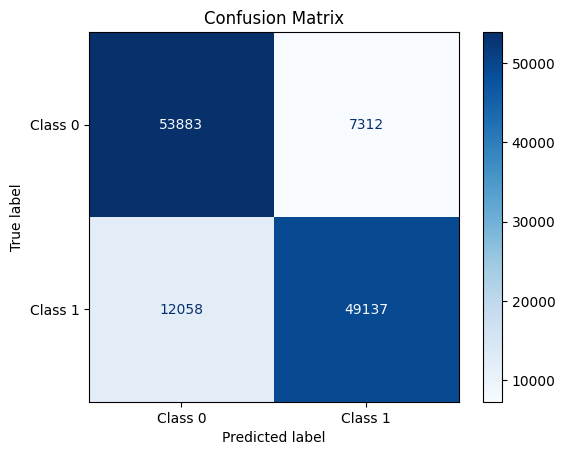

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()